In [4]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt2",          # --job-name
    cores=2,                     # Number of cores per task (adjust if needed)
    processes=2,                 # One process per task
    memory="20GB",               # --mem
    walltime="00:15:00",         # --time
    queue="short",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)

import glob 
import os

AttributeError: partially initialized module 'yaml' from '/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/yaml/__init__.py' has no attribute 'error' (most likely due to a circular import)

In [2]:
data_dir = '/home1/nalex2023/Datasets/interpsonde_manus/*.nc'

all_dsets = glob.glob(data_dir)

all_dsets

['/home1/nalex2023/Datasets/interpsonde_manus/2009_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2002_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2003_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2008_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2014_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2004_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2013_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2012_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2005_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2010_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2007_MANUS_INTERPSONDEv2.nc',
 '/home1/nalex2023/Datasets/interpsonde_manus/2006_MANUS_INTERPSONDEv2.nc',
 '/home1/nal

In [3]:
from dask.distributed import Client
cluster.scale(jobs=10)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:40509,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
import xarray as xr 
import pandas as pd
import numpy as np

dset = xr.open_mfdataset(all_dsets, combine='by_coords')
dset['time'] = dset['time'] + pd.Timedelta('10 hour')


In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes


def create_dft(in_dir,arm_data=True):
    files = glob.glob(in_dir+os.sep+'*.nc')
    if len(files) == 0:
        files = glob.glob(in_dir+os.sep+'*.cdf')
        if len(files) == 0:
            raise Exception('No files Found')
        else:
            pass
    else:
        pass
    
    dft = pd.DataFrame(files,columns=['filepath'])
    dft['filename'] = dft['filepath'].str.split(os.sep).str[-1]
    
    if arm_data:
        dft['datetime'] = pd.to_datetime(dft['filename'].str.split(
            '.',
            expand=True).iloc[:, 2] + dft['filename'].str.split(
                '.',  expand=True).iloc[:, 3],format='%Y%m%d%H%M%S')


    return dft

In [10]:
dset['angle'] = (90 - np.degrees(np.arctan2(-dset['u_wind'], -dset['v_wind']))) % 360

dset['speed'] = np.sqrt((dset['u_wind'] * dset['u_wind']) + 
                        (dset['v_wind'] * dset['v_wind']))

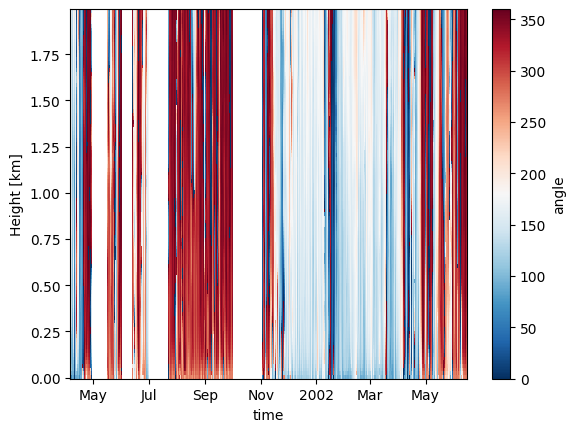

In [11]:
dset['angle'].sel(height=slice(0,2)).isel(time=slice(0,24*364)).plot(x='time',
                                          cmap='RdBu_r')

In [12]:
def draw_windrose(data,color=cm.Blues):
    ws = data['speed'].values
    wd = data['angle'].values
    ax = WindroseAxes.from_ax()
    ax.bar(wd,ws,normed=False,cmap=color)
    ax.set_legend()


def wind_rose_compare(data1,data2 ,cost_angle):
    ws1 = data1['speed'].values
    wd1 = data1['angle'].values
    ws2 = data2['speed'].values
    wd2 = data2['angle'].values
    
    ax = WindroseAxes.from_ax()
    
    ax.bar(wd1,ws1,normed=False,cmap=cm.Reds)
    ax.set_legend(loc='lower right')
    ax.bar(wd2,ws2,normed=False,cmap=cm.Blues)
    ax.set_legend(loc='lower left')

In [13]:
alpha  = dset.sel(height=0.01,method='nearest').compute()#.sel(hour=slice(12,19))
beta = dset.sel(height=slice(2,3)).mean(dim='height').compute()#.sel(hour=slice(12,19))

<xarray.Dataset> Size: 312kB
Dimensions:   (time: 7807)
Coordinates:
  * time      (time) datetime64[ns] 62kB 2001-04-06T05:00:00 ... 2014-07-06T1...
    height    float32 4B 0.004
Data variables:
    bar_pres  (time) float32 31kB 101.0 101.0 101.0 101.0 ... 100.9 100.9 100.9
    temp      (time) float32 31kB 31.24 31.28 31.32 31.36 ... 28.18 27.78 27.39
    dp        (time) float32 31kB 25.55 25.61 25.67 25.73 ... 23.81 23.8 23.79
    rh        (time) float32 31kB 73.38 73.46 73.54 73.63 ... 77.57 79.48 81.4
    u_wind    (time) float32 31kB -2.08 -2.054 -2.027 ... -0.5952 -0.4156
    v_wind    (time) float32 31kB -0.02331 -0.1006 -0.1779 ... -0.02297 -0.02431
    angle     (time) float32 31kB 0.6422 2.805 5.015 7.268 ... 1.599 2.21 3.348
    speed     (time) float32 31kB 2.08 2.056 2.035 ... 0.7752 0.5957 0.4163
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

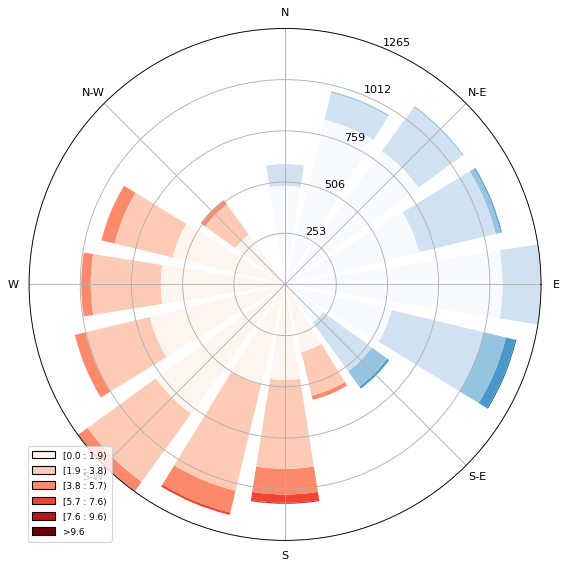

In [14]:
cost_angle = 45


alpha_fil = alpha.where((cost_angle-90 < alpha['angle']) &  
                        (alpha['angle']< cost_angle+90),drop=True)


opposite_cost = cost_angle + 180
beta_fil = beta.where((opposite_cost-90 < beta['angle']) & 
                      (beta['angle'] < opposite_cost+90),drop=True)



low_winds = alpha_fil['angle'] + 180
beta_fil2 = beta_fil.where((low_winds - 90 < beta_fil['angle']) & 
                           (beta_fil['angle'] < low_winds + 90),drop=True) 


mask = beta_fil2.time



alpha_fil2 = alpha_fil.reindex(time=mask)


wind_rose_compare(data1=beta_fil2,data2=alpha_fil2,cost_angle=270)

alpha_fil2

(array([275.,  77., 241.,  72.,  70., 373.,  76., 106., 284.,  81., 438.,
         93., 102., 244., 131., 150., 296., 126., 262., 124., 144., 354.,
        191., 206., 927., 208., 345., 126., 137., 293., 160., 140., 319.,
        136., 352., 148.]),
 array([  0.        ,   3.74980259,   7.49960518,  11.24940777,
         14.99921036,  18.74901199,  22.49881554,  26.24861908,
         29.99842072,  33.74822235,  37.49802399,  41.24782944,
         44.99763107,  48.74743271,  52.49723816,  56.24703979,
         59.99684143,  63.74664307,  67.4964447 ,  71.24624634,
         74.99604797,  78.74585724,  82.49565887,  86.24546051,
         89.99526215,  93.74506378,  97.49486542, 101.24466705,
        104.99447632, 108.74427795, 112.49407959, 116.24388123,
        119.99368286, 123.7434845 , 127.49328613, 131.24308777,
        134.9928894 ]),
 <BarContainer object of 36 artists>)

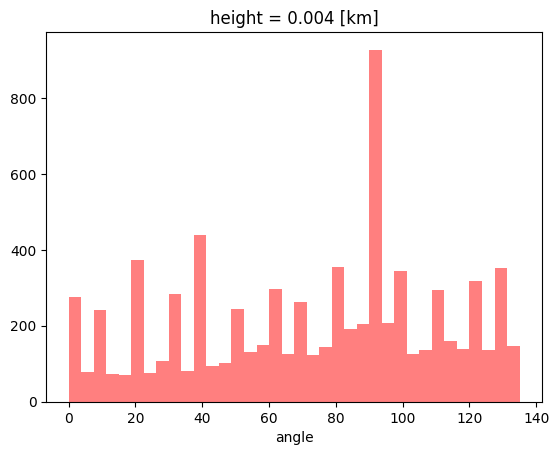

In [15]:
alpha_fil2['angle'].plot.hist(bins=36,facecolor='red',alpha=0.5)

In [16]:
SBI = np.cos(alpha_fil2['angle'] - cost_angle) * np.cos((alpha_fil2['angle'] + 180) - beta_fil2['angle'])



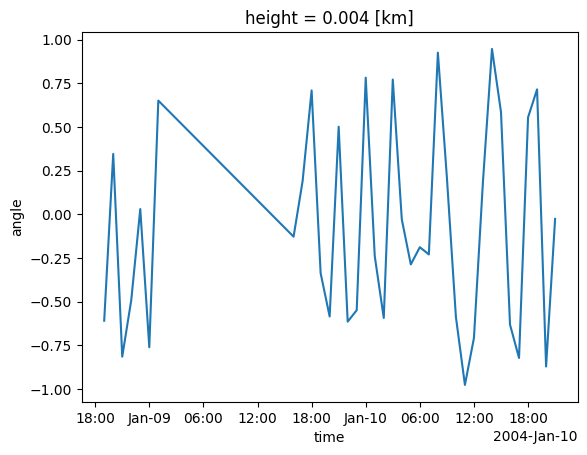

In [17]:
SBI.sel(time=slice('2004-01-01','2004-01-10')).plot()

In [11]:

met_manus_fol = '/home1/nalex2023/Datasets/met_manus'

all_ncfiles = create_dft(met_manus_fol)

all_ncfiles = all_ncfiles.sort_values('datetime')

def prepro(ds):
    ds_new = ds.resample(time='1H').mean()
    return ds_new

final_dset = xr.open_mfdataset(all_ncfiles['filepath'].values,combine='by_coords')



ValueError: Resulting object does not have monotonic global indexes along dimension time